<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [59]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-03-02 20:28:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-03-02 20:28:22 (13.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [159]:
df = pd.read_csv('loan_train.csv')

In [160]:
df.shape

(346, 10)

### Convert to date time object 

In [161]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [162]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

the result will bias towards PAIDOFF

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [64]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


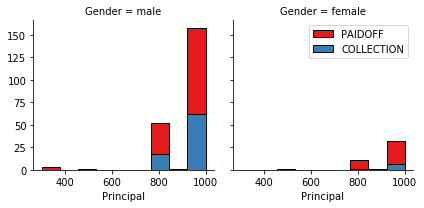

In [163]:
import seaborn as sns
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

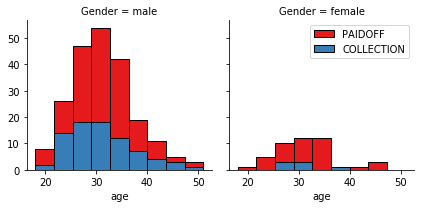

In [164]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

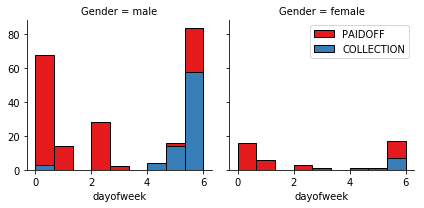

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [165]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

### Lets look at the day of the week when the loan due

We see people pay off loan more when the due day are in the weekdays. So let binarized the value when due day of week is in day1, day2 and day3.

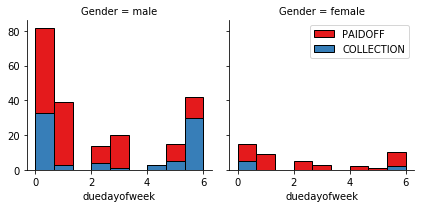

In [166]:
df['duedayofweek'] = df['due_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'duedayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [167]:
df['dueweekday'] = df['duedayofweek'].apply(lambda x: 1 if (x in [1,2,3])  else 0)
df.groupby(['dueweekday'])['loan_status'].value_counts(normalize =1)

dueweekday  loan_status
0           PAIDOFF        0.685484
            COLLECTION     0.314516
1           PAIDOFF        0.918367
            COLLECTION     0.081633
Name: loan_status, dtype: float64

### Let Check Principal Value

We see people pay off loan more when the loan value is small. 

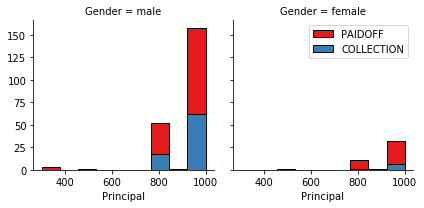

In [168]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [169]:
df.groupby(['Principal'])['loan_status'].value_counts(normalize=True)

Principal  loan_status
300        PAIDOFF        1.000000
500        PAIDOFF        1.000000
800        PAIDOFF        0.777778
           COLLECTION     0.222222
900        PAIDOFF        1.000000
1000       PAIDOFF        0.736434
           COLLECTION     0.263566
Name: loan_status, dtype: float64

## Convert Categorical features to numerical values

Lets look at gender:

In [170]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [171]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,duedayofweek,dueweekday
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,4,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,4,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,3,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,5,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,5,0


## One Hot Encoding  
#### How about education?

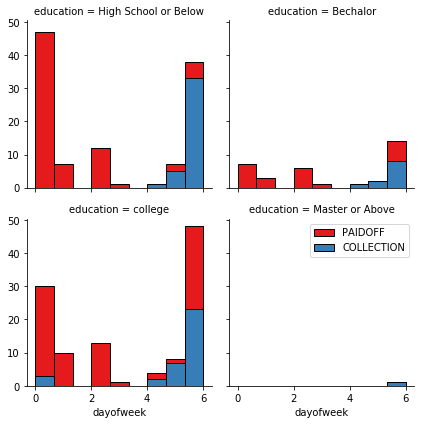

In [172]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
df.groupby(['education'])['loan_status'].value_counts(normalize=True)
g = sns.FacetGrid(df,col='education',hue='loan_status',palette='Set1',col_wrap=2)
g.map(plt.hist,'dayofweek',bins=bins, ec="k")
g.axes[-1].legend()

#### Feature befor One Hot Encoding

In [173]:
df[['Principal','age','Gender','education']].head()

,Principal,age,Gender,education
0,1000,45,0,High School or Below
1,1000,33,1,Bechalor
2,1000,27,0,college
3,1000,28,1,college
4,1000,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [174]:
Feature = df[['Principal','age','Gender','weekend','dueweekday']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
Feature.columns

Index(['Principal', 'age', 'Gender', 'weekend', 'dueweekday', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')

### Feature selection

Lets defind feature sets, X:

In [175]:
X = Feature
X[0:5]

,Principal,age,Gender,weekend,dueweekday,Bechalor,High School or Below,college
0,1000,45,0,0,0,0,1,0
1,1000,33,1,0,0,1,0,0
2,1000,27,0,0,1,0,0,1
3,1000,28,1,1,0,0,0,1
4,1000,29,0,1,0,0,0,1


What are our lables?

In [176]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [177]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X

array([[ 0.51578458,  2.33152555, -0.42056004, ..., -0.38170062,
         1.13639374, -0.86968108],
       [ 0.51578458,  0.34170148,  2.37778177, ...,  2.61985426,
        -0.87997669, -0.86968108],
       [ 0.51578458, -0.65321055, -0.42056004, ..., -0.38170062,
        -0.87997669,  1.14984679],
       ..., 
       [-1.31458942,  1.33661351, -0.42056004, ..., -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458, -0.48739188, -0.42056004, ..., -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458, -0.81902922, -0.42056004, ..., -0.38170062,
        -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Split the dataset to train and test data set

In [178]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
y_train.shape

(276,)

In [181]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

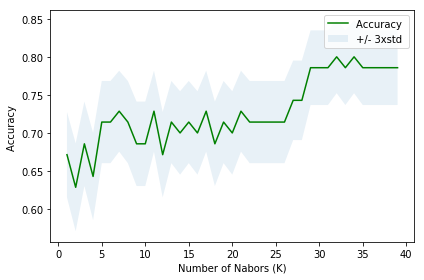

The best jaccard_similarity_score was with 0.8 with k= 32


In [275]:
Ks = 40
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = jaccard_similarity_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best jaccard_similarity_score was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [276]:
k =32
neigh1 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh1
yhat = neigh1.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [277]:
print("Test set jaccard_similarity_score: ", jaccard_similarity_score(y_test, yhat))
print("Test set f1_score for PAIDOFF: ", f1_score(y_test, yhat,pos_label='PAIDOFF'))

Test set jaccard_similarity_score:  0.8
Test set f1_score for PAIDOFF:  0.887096774194


# Decision Tree

In [278]:
from sklearn.tree import DecisionTreeClassifier

Max Acc:  0.785714285714 Depth:  [1, 2]


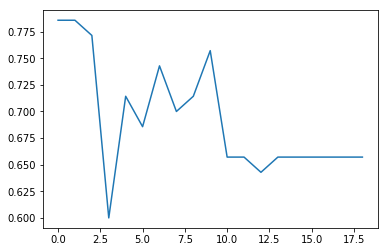

In [280]:
depthlist = list(range(1,20,1))
Acc=np.zeros(len(depthlist))
for i,d in enumerate(depthlist):
    DesTree = DecisionTreeClassifier(criterion="entropy", max_depth =d)
    DesTree.fit(X_train,y_train)
    predTree = DesTree.predict(X_test)
    Acc[i] = metrics.jaccard_similarity_score(y_test, predTree)
plt.plot(Acc)
print("Max Acc: ", Acc.max(), "Depth: ", [i+1 for i, e in enumerate(Acc) if e==Acc.max()])

In [281]:
DesTree = DecisionTreeClassifier(criterion="entropy", max_depth =2)
DesTree.fit(X_train,y_train)
predTree = DesTree.predict(X_test)
print("Test set's jaccard_similarity_score: ", metrics.jaccard_similarity_score(y_test, predTree))
print("Test set F1 score for PAIDOFF: ", f1_score(y_test, predTree,pos_label='PAIDOFF'))

Test set's jaccard_similarity_score:  0.785714285714
Test set F1 score for PAIDOFF:  0.88


In [210]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y


Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    pydotplus: 2.0.2-py_2 conda-forge

pydotplus-2.0. 100% |################################| Time: 0:00:00  19.63 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    python-graphviz: 0.10.1-py_0 conda-forge

python-graphvi 100% |################################| Time: 0:00:00  14.95 MB/s


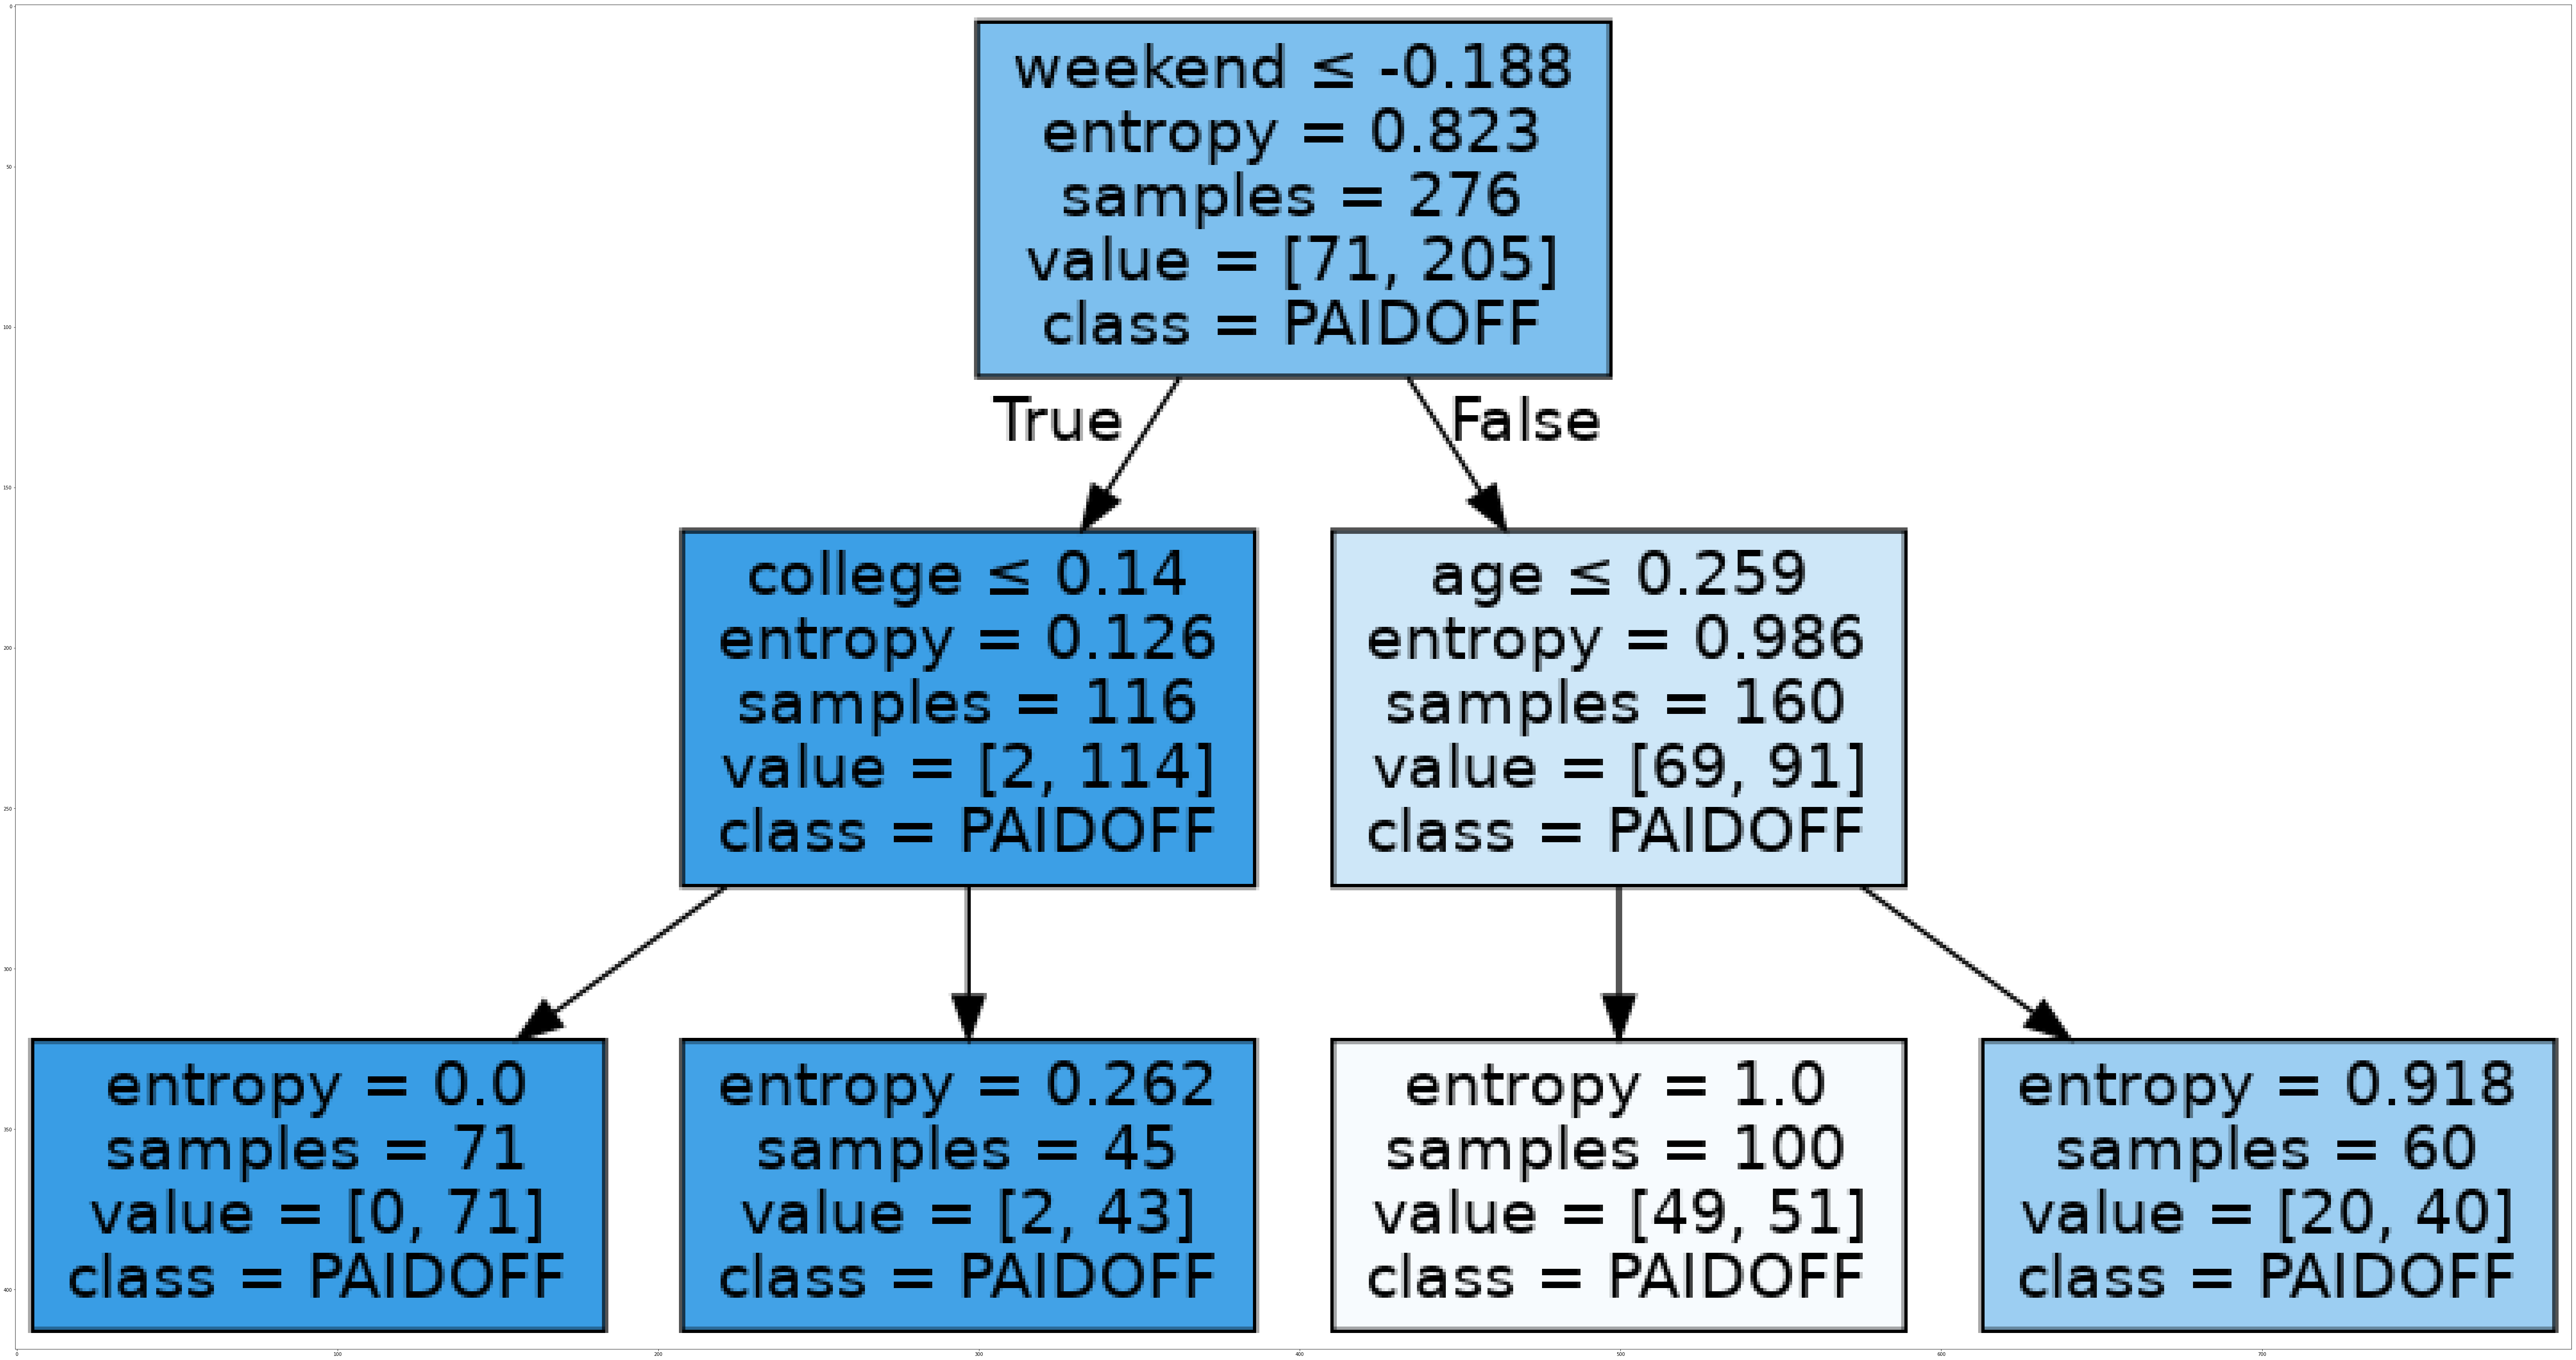

In [216]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "DEStree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(DesTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### RandomForestClassifier

##### Random Forest Classifier was not in the class scope, tested here for self-interest only; after testing, found it needs more detail test and will study it more with bigger data set. 

In [208]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=1,n_estimators=5,max_depth=3)

# fit your model
rf_model.fit(X_train,y_train)
predTree = rf_model.predict(X_test)

# Calculate the mean absolute error of your Random Forest model on the validation data
print("RandomForest's Accuracy: ", metrics.accuracy_score(y_test, predTree))
rf_model.feature_importances_


RandomForest's Accuracy:  0.785714285714


array([ 0.00867537,  0.16126363,  0.00211081,  0.53779101,  0.23490401,
        0.0326314 ,  0.01990627,  0.0027175 ])

In [217]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "RFtree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(rf_model.estimators_[0],feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph2 = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph2.write_png(filename)

True

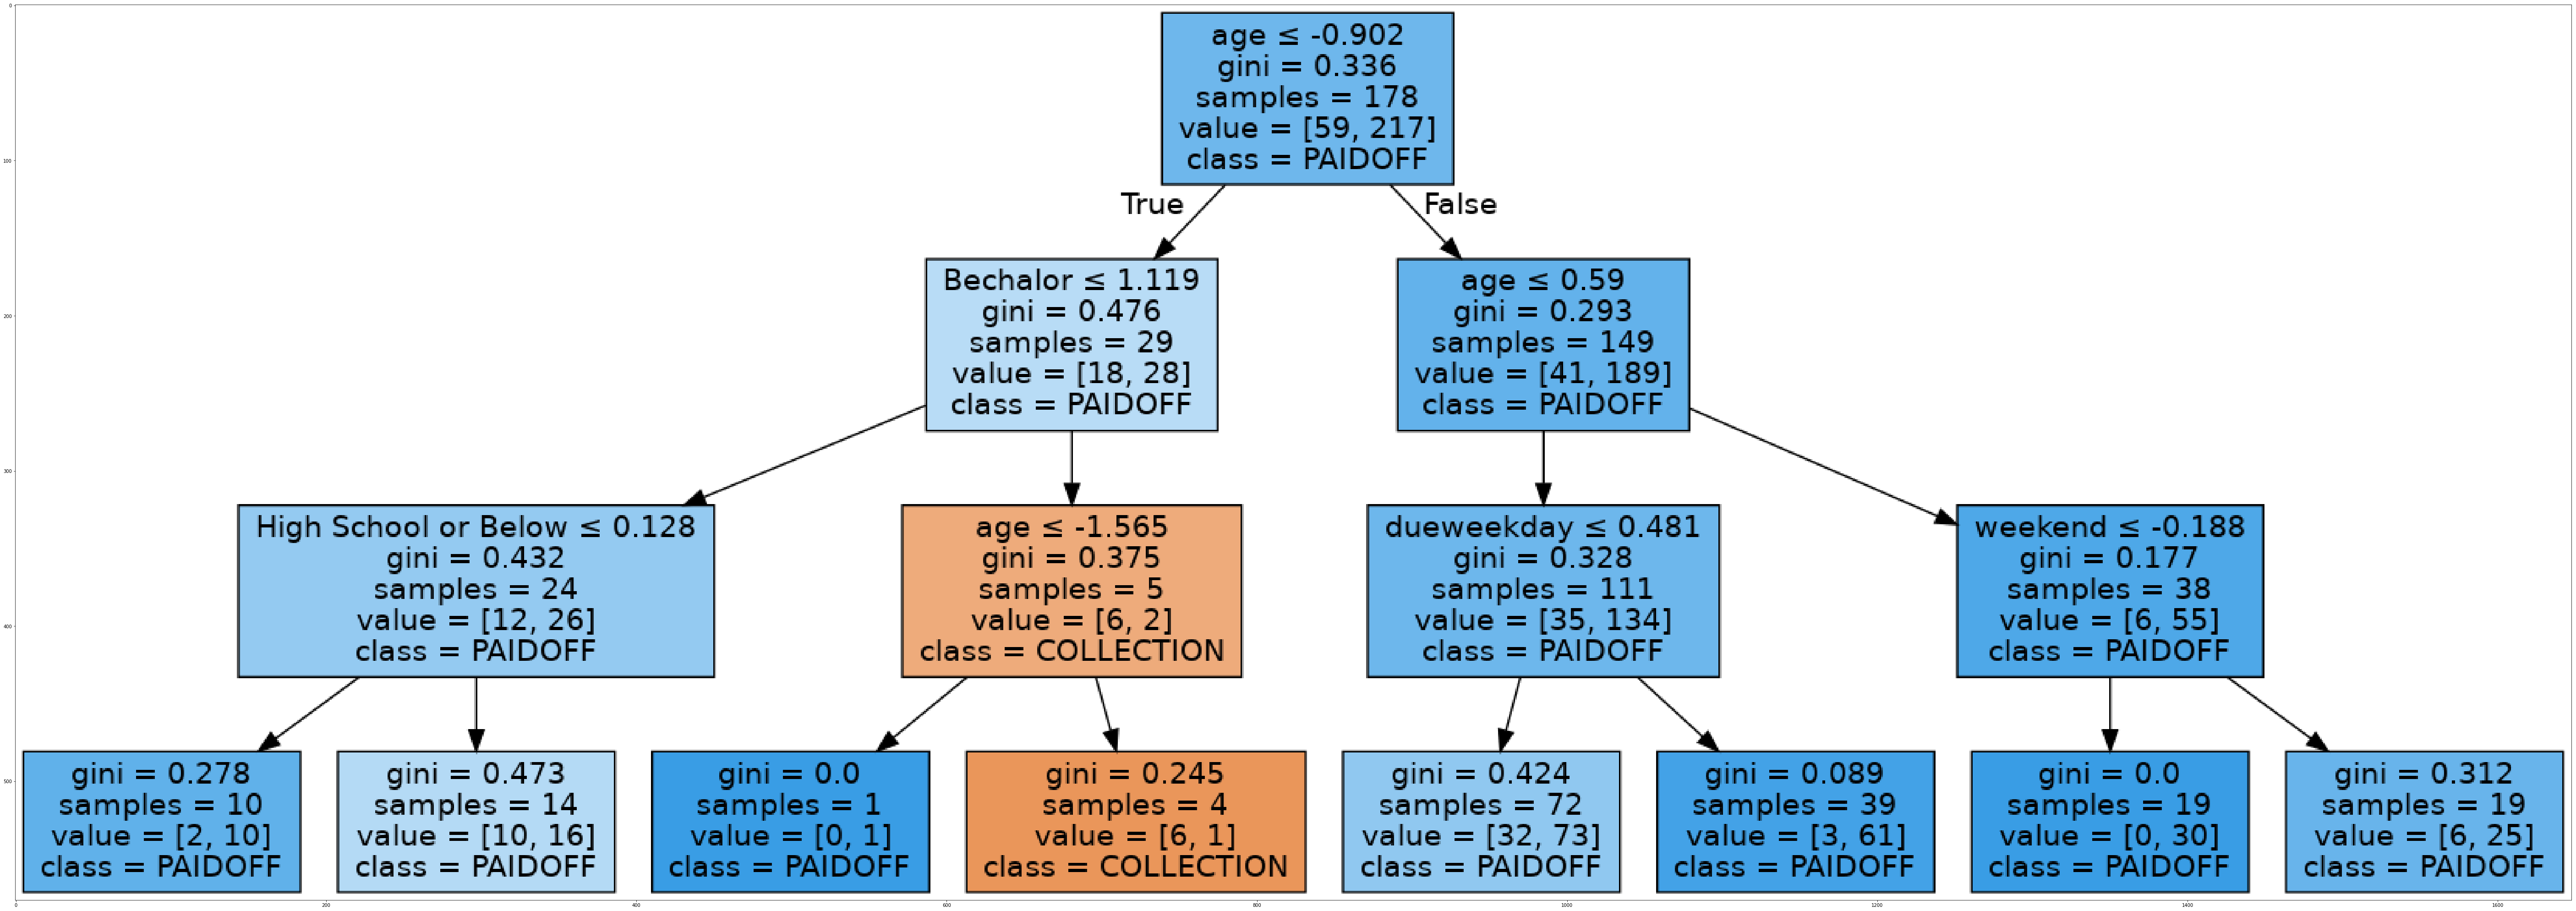

In [218]:
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [134]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)

In [282]:
print("Test set jaccard_similarity_score: ", metrics.jaccard_similarity_score(y_test, yhat))
print("Test set f1_score for PAIDOFF: ", f1_score(y_test, yhat,pos_label='PAIDOFF'))

Test set jaccard_similarity_score:  0.8
Test set f1_score for PAIDOFF:  0.887096774194


# Logistic Regression

In [235]:
from sklearn.linear_model import LogisticRegression

In [284]:
Acc =  []
F1p = []
F1c = []
LogL = []
Clist = []
for c in np.arange(0.01,0.5,0.01):
    LR = LogisticRegression(C=c, solver='liblinear').fit(X_train,y_train)
    ypreLR = LR.predict(X_test)
    pT = LR.predict_proba(X_test)
    Clist.append(c)
    F1p.append(f1_score(y_test, ypreLR,pos_label='PAIDOFF'))
    LogL.append(log_loss(y_test, pT,normalize='True'))
    Acc.append(metrics.jaccard_similarity_score(y_test, ypreLR))

In [285]:
max(Acc)

0.74285714285714288

In [286]:
[i*0.01+0.01 for i,e in enumerate(Acc) if e==max(Acc)]

[0.15000000000000002]

In [287]:
LR = LogisticRegression(C=0.15, solver='liblinear').fit(X_train,y_train)
ypreLR = LR.predict(X_test)
pT = LR.predict_proba(X_test)
print("jaccard_similarity_score: ", metrics.jaccard_similarity_score(y_test, ypreLR))
print("f1_score for PAIDOFF: ", f1_score(y_test, ypreLR,pos_label='PAIDOFF'))
print("log_loss: ", log_loss(y_test, pT,normalize='True'))

jaccard_similarity_score:  0.742857142857
f1_score for PAIDOFF:  0.847457627119
log_loss:  0.495044451495


# Model Evaluation using Test set

In [240]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [241]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-03-02 22:15:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-03-02 22:15:40 (660 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [242]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [248]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['duedayofweek'] = test_df['due_date'].dt.dayofweek
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,duedayofweek,weekend,dueweekday
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,4,0,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,3,1,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,6,1,0
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,6,1,0
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,6,1,0


In [247]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['dueweekday'] = test_df['duedayofweek'].apply(lambda x: 1 if (x in [1,2,3])  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature = test_df[['Principal','age','Gender','weekend','dueweekday']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
Feature.columns

Index(['Principal', 'age', 'Gender', 'weekend', 'dueweekday', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')

In [264]:
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)
y = test_df['loan_status'].values
len(y)
X.shape

(54, 8)

### KNN Test Dataset

In [288]:
yhat = neigh1.predict(X)
print("Test set jaccard_similarity_score: ", metrics.jaccard_similarity_score(y, yhat))
print("Test set f1_score for PAIDOFF: ", f1_score(y, yhat,pos_label='PAIDOFF'))

Test set jaccard_similarity_score:  0.740740740741
Test set f1_score for PAIDOFF:  0.847826086957


### Desicion Tree Test Dataset

In [289]:
predTree = DesTree.predict(X)
print("Test set's jaccard_similarity_score: ", metrics.jaccard_similarity_score(y, predTree))
print("Test set F1 score for PAIDOFF: ", f1_score(y, predTree,pos_label='PAIDOFF'))

Test set's jaccard_similarity_score:  0.740740740741
Test set F1 score for PAIDOFF:  0.851063829787


### SVM Test Dataset

In [290]:
yhat = clf.predict(X)
print("Test set jaccard_similarity_score: ", metrics.jaccard_similarity_score(y, yhat))
print("Test set f1_score for PAIDOFF: ", f1_score(y, yhat,pos_label='PAIDOFF'))

Test set jaccard_similarity_score:  0.703703703704
Test set f1_score for PAIDOFF:  0.826086956522


### Logistic Regression Test Dataset

In [291]:
ypreLR = LR.predict(X)
pT = LR.predict_proba(X)
print("jaccard_similarity_score: ", metrics.jaccard_similarity_score(y, ypreLR))
print("f1_score for PAIDOFF: ", f1_score(y, ypreLR,pos_label='PAIDOFF'))
print("log_loss: ", log_loss(y, pT,normalize='True'))

jaccard_similarity_score:  0.703703703704
f1_score for PAIDOFF:  0.818181818182
log_loss:  0.476124427345


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.741      | 0.848        | NA      |
| Decision Tree      | 0.741       | 0.851        | NA      |
| SVM                | 0.704       | 0.826        | NA      |
| LogisticRegression | 0.704      | 0.818        | 0.476       |

## Conclusion

#### 1.Predict loan status with four classifiers, KNN, Decision Tree, SVM and LogisticRegression.
#### 2.Calculate Jaccard Similarity, F1-score, Logloss for each classifier. Decision Tree has the best performace.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>